<p style="color:grey">This work was largely inspired by Hvass Labs work on the same (Thank you!)</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# English to romanian MT


In [3]:
data = pd.read_csv("../input/europarl-parallel-corpus-19962011/english_romanian.csv")
data = data.dropna()
data.head(10)

,English,Romanian
0,Membership of Parliament: see Minutes,Componenţa Parlamentului: a se vedea procesul-...
1,Approval of Minutes of previous sitting: see M...,Aprobarea procesului-verbal al şedinţei preced...
2,Membership of Parliament: see Minutes,Componenţa Parlamentului: a se vedea procesul-...
3,Verification of credentials: see Minutes,Verificarea prerogativelor: a se vedea procesu...
4,Documents received: see Minutes,Depunere de documente: a se vedea procesul-verbal
5,Written statements and oral questions (tabling...,Declaraţii scrise şi întrebări orale (depunere...
6,Petitions: see Minutes,Petiţii: a se vedea procesul-verbal
7,Texts of agreements forwarded by the Council: ...,Transmiterea de către Consiliu a textelor acor...
8,Action taken on Parliament's resolutions: see ...,Cursul dat rezoluţiilor Parlamentului: a se ve...
9,Agenda for next sitting: see Minutes,Ordinea de zi a următoarei şedinţe: a se vedea...


In [4]:
eng_data = data['English']
eng_data.head()

0                Membership of Parliament: see Minutes
1    Approval of Minutes of previous sitting: see M...
2                Membership of Parliament: see Minutes
3             Verification of credentials: see Minutes
4                      Documents received: see Minutes
Name: English, dtype: object

In [6]:
data.shape

(399251, 2)

In [7]:
# Append <START> and <END> to each english sentence
START = 'ssss '
END = ' eeee'

data['English'] = data['English'].apply(lambda x: START+x+END)
data.head()

,English,Romanian
0,ssss Membership of Parliament: see Minutes eeee,Componenţa Parlamentului: a se vedea procesul-...
1,ssss Approval of Minutes of previous sitting: ...,Aprobarea procesului-verbal al şedinţei preced...
2,ssss Membership of Parliament: see Minutes eeee,Componenţa Parlamentului: a se vedea procesul-...
3,ssss Verification of credentials: see Minutes ...,Verificarea prerogativelor: a se vedea procesu...
4,ssss Documents received: see Minutes eeee,Depunere de documente: a se vedea procesul-verbal


In [8]:
eng_text = data['English'].tolist()
deu_text = data['Romanian'].tolist()

print(eng_text[5])
print(deu_text[5])
print(eng_text[6])
print(deu_text[6])
print(eng_text[7])
print(deu_text[7])

ssss Written statements and oral questions (tabling): see Minutes eeee
Declaraţii scrise şi întrebări orale (depunere): consultaţi procesul-verbal
ssss Petitions: see Minutes eeee
Petiţii: a se vedea procesul-verbal
ssss Texts of agreements forwarded by the Council: see Minutes eeee
Transmiterea de către Consiliu a textelor acordurilor: a se vedea procesul-verbal


In [9]:
num_words = 10000

class TokenizerWrap(Tokenizer):
    """
    Wrap the Tokenizer-class from Keras with more functionality.
    mở rộng từ Tokenizer của Keras với nhiều chức năng hơn.
    """
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        # Tạo từ điển từ các từ trong văn bản, đều là các unique word thuộc cả 2 ngôn ngữ, 
        # phương thức cũng ánh xạ luôn mỗi từ thành 1 số nguyên duy nhất.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        # Tạo ánh xạ ngược từ số nguyên thành từ.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        # Chuyển đổi tất cả các văn bản thành danh sách các token số nguyên (self.tokens).
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            # Reverse the token-sequences.
            self.tokens = [list(reversed(x)) for x in self.tokens]
        
            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        # The number of integer-tokens in each sequence.
        # Tính toán số lượng token trong mỗi sequence.
        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        # This is a compromise so we save a lot of memory and
        # only have to truncate maybe 5% of all the sequences.
        # Tính toán số lượng token tối đa để sử dụng trong tất cả các sequence.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)

        # Pad / truncate all token-sequences to the given length.
        # This creates a 2-dim numpy matrix that is easier to use.
        # Thực hiện padding hoặc cắt ngắn tất cả các danh sách token để có độ dài cố định.
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)

    def token_to_word(self, token):
        """
        Lookup a single word from an integer-token.
        Chuyển đổi một token số nguyên thành từ tương ứng
        """

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """
        Convert a list of integer-tokens to a string.
        Chuyển đổi một danh sách các token số nguyên thành một chuỗi văn bản.
        """

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        Chuyển đổi một chuỗi văn bản thành danh sách các token số nguyên, 
        với tùy chọn đảo ngược và padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            # Reverse the tokens.
            tokens = np.flip(tokens, axis=1)

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        if padding:
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)

        return tokens

In [10]:
%%time
tokenizer_src = TokenizerWrap(texts=deu_text,
                              padding='pre',
                              reverse=True,
                              num_words=num_words
                             )

CPU times: user 38.3 s, sys: 177 ms, total: 38.4 s
Wall time: 38.4 s


In [11]:
%%time
tokenizer_des = TokenizerWrap(texts=eng_text,
                              padding='post',
                              reverse=False,
                              num_words=num_words
                             )

CPU times: user 26.5 s, sys: 97.1 ms, total: 26.6 s
Wall time: 26.6 s


In [12]:
token_src = tokenizer_src.tokens_padded
token_des = tokenizer_des.tokens_padded

print(token_src.shape)
print(token_des.shape)

(399251, 50)
(399251, 54)


* ở đây có thể thấy có khoảng 400k câu, mỗi câu trong tiếng roma (src) chứa khoảng 50 token sau khi bị padding hoặc cắt ngắn
* tương tự với các câu tiếng anh (des) chứa khoảng 54 token sau khi xử lý. <br>
(2 thằng này có shape khác nhau do độ dài max của các ngôn ngữ khác nhau. )

In [13]:
token_start = tokenizer_des.word_index[START.strip()]
token_end = tokenizer_des.word_index[END.strip()]

print(token_start)
print(token_end)

2
3


## Model

In [14]:
encoder_inp_data = token_src
decoder_inp_data = token_des[:, :-1]
decoder_out_data = token_des[:, 1:]

### Encoder Model

In [15]:
# Glue all the encoder components together
def connect_encoder():
    net = encoder_input
    
    net = encoder_emb(net)
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    out = encoder_gru3(net)
    
    return out

### Decoder Model

In [16]:
def connect_decoder(initial_state):    
    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_emb(net)
    
    # Connect all the GRU-layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [17]:
# Connect all the models
with strategy.scope():
    
    embedding_size = 128
    state_size = 512

    encoder_input = Input(shape=(None,), name='encoder_input')
    encoder_emb = Embedding(input_dim=num_words, output_dim=embedding_size, name='encoder_embedding')

    encoder_gru1 = GRU(state_size, name='enc_gru1', return_sequences=True)
    encoder_gru2 = GRU(state_size, name='enc_gru2', return_sequences=True)
    encoder_gru3 = GRU(state_size, name='enc_gru3', return_sequences=False)
    
    encoder_op = connect_encoder()
    
    # Initial state placeholder takes a "thought vector" produced by the GRUs
    # That's why it needs the inputs with "state_size" (which was used in GRU size)
    decoder_initial_state = Input(shape=(state_size,), name='decoder_init_state')

    # Decoder also needs an input, which is the basic input setence of the destination language
    decoder_input = Input(shape=(None,), name='decoder_input')

    # Have the decoder embedding
    decoder_emb = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')

    # GRU arch similar to Encoder one with small changes
    decoder_gru1 = GRU(state_size, name='dec_gru1', return_sequences=True)
    decoder_gru2 = GRU(state_size, name='dec_gru2', return_sequences=True)
    decoder_gru3 = GRU(state_size, name='dec_gru3', return_sequences=True)

    # Final dense layer for prediction
    decoder_dense = Dense(num_words, activation='softmax', name='decoder_output')
    decoder_op = connect_decoder(encoder_op)
    model_train = Model(inputs=[encoder_input, decoder_input],
                        outputs=[decoder_op])
    model_train.compile(optimizer=RMSprop(lr=1e-3),
                        loss='sparse_categorical_crossentropy')

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


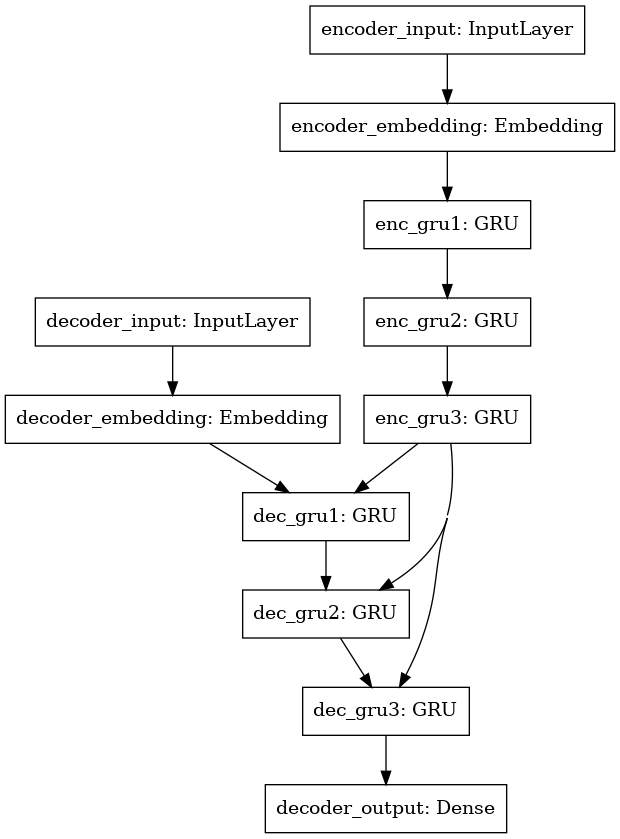

In [18]:
tf.keras.utils.plot_model(model_train)

In [19]:
path_checkpoint = '21_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [20]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

In [21]:
callbacks = [callback_early_stopping,
             callback_checkpoint]

In [22]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
[Errno 2] Unable to open file (unable to open file: name = '21_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [23]:
x_data = {
    "encoder_input": encoder_inp_data,
    "decoder_input": decoder_inp_data
}

y_data = {
    "decoder_output": decoder_out_data
}

In [24]:
validation_split = 10000 / len(encoder_inp_data)
print(f"Validation Split: {validation_split:.4f}%")

Validation Split: 0.0250%


In [25]:
# Train the model
with strategy.scope():
    model_train.fit(
        x=x_data,
        y=y_data,
        batch_size=384,
        epochs=,
        validation_split=validation_split,
        callbacks=callbacks
    )

1014/1014 [==============================] - 523s 502ms/step - loss: 2.4266 - val_loss: 1.8995

Epoch 00001: val_loss improved from inf to 1.89955, saving model to 21_checkpoint.keras


In [26]:
model_train.save("eng_to_deu.hdf5")

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

In [45]:

# Load the saved model
model = model_train

In [46]:
model

# Test english to romanian/

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Step 2: Preprocess the new sentence
def preprocess_sentence(sentence, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

# Step 3: Translate the sentence
def translate_sentence(model, sentence, tokenizer, max_length):
    preprocessed_sentence = preprocess_sentence(sentence, tokenizer, max_length)
    # Create a dummy decoder input (e.g., start token)
    decoder_input_data = np.zeros((1, max_length))
    decoder_input_data[0, 0] = tokenizer.word_index['start']  # Replace 'start' with your actual start token
    prediction = model.predict([preprocessed_sentence, decoder_input_data])
    return prediction

# Step 4: Post-process the output
def decode_sequence(prediction, tokenizer):
    index_to_word = {index: word for word, index in tokenizer.word_index.items()}
    decoded_sentence = ' '.join([index_to_word.get(index, '') for index in np.argmax(prediction, axis=-1)[0]])
    return decoded_sentence


In [54]:

# Example usage
english_sentence = "how are you"

# Assuming tokenizer_des and max_length are already defined
# Translate the sentence
translated_sentence = translate_sentence(model, english_sentence, tokenizer_des, max_length)
# Decode the translated sentence
romanian_sentence = decode_sequence(translated_sentence, tokenizer_des)

print("Translated Sentence:", romanian_sentence)

Translated Sentence: applause                   
